# 基准模型1:不进行额外特征工程，仅仅使用随机森林回归。

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 抑制 scikit-learn 的 UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# 设置样式和随机种子
sns.set_style("whitegrid")
np.random.seed(42)

In [2]:
# --- 数据加载 ---
col_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
col_names += [f'sensor_{i}' for i in range(1, 22)]
train_df = pd.read_csv("train_FD004.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD004.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD004.txt", sep="\s+", header=None, names=['RUL'])

In [3]:
# --- 1. 特征选择 ---
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
constant_cols = [col for col in sensor_cols if train_df[col].nunique() == 1]
features_to_use = [col for col in sensor_cols if col not in constant_cols]
print(f"使用的传感器特征: {features_to_use}")

# --- 2. 为训练数据添加分段RUL ---
def process_targets(data_length, early_rul=125):
    """创建分段线性的目标RUL序列。"""
    if early_rul is None:
        return np.arange(data_length - 1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length - 1, -1, -1)
        else:
            return np.append(early_rul * np.ones(shape=(early_rul_duration,)), 
                             np.arange(early_rul - 1, -1, -1))

# 为每个引擎应用RUL计算
rul = pd.DataFrame(train_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_number', 'max_cycles']
train_df = pd.merge(train_df, rul, on=['unit_number'], how='left')
train_df['RUL_actual'] = train_df['max_cycles'] - train_df['time_in_cycles']
train_df.drop(columns=['max_cycles'], inplace=True)

early_rul_threshold = 125
rul_labels = train_df.groupby('unit_number')['RUL_actual'].apply(lambda x: process_targets(len(x), early_rul=early_rul_threshold))
train_df['RUL'] = rul_labels.explode().astype(int).values
train_df.drop(columns=['RUL_actual'], inplace=True)

print("\n处理后的训练数据尺寸:", train_df.shape)

使用的传感器特征: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

处理后的训练数据尺寸: (61249, 27)


In [4]:
# 准备训练数据
# X_train 包含了所有引擎、所有工况的数据点
X_train = train_df[features_to_use]
y_train = train_df['RUL']

print("训练模型...")
# 初始化并训练随机森林回归器
benchmark_model = RandomForestRegressor(
    n_estimators=100, 
    max_features="sqrt", 
    n_jobs=-1, 
    random_state=42
)
benchmark_model.fit(X_train, y_train)

print("模型训练完成！")

训练模型...
模型训练完成！


In [5]:
# 准备测试数据：提取每个测试引擎的最后一条记录
test_last_points_df = test_df.groupby('unit_number').last()
X_test = test_last_points_df[features_to_use]

# 进行预测
print("进行预测...")
predictions = benchmark_model.predict(X_test)

# 获取真实的RUL值
true_rul = true_rul_df['RUL'].values

# --- 评估结果 ---
print("\n--- 评估结果 ---")
rmse = np.sqrt(mean_squared_error(true_rul, predictions))
print(f"基准模型 - 整体均方根误差 (RMSE): {rmse:.4f}")

def compute_s_score(rul_true, rul_pred):
    """计算非对称的S-score"""
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff / 13) - 1, np.exp(diff / 10) - 1))

s_score = compute_s_score(true_rul, predictions)
print(f"基准模型 - 整体 S-score: {s_score:.4f}")

进行预测...

--- 评估结果 ---
基准模型 - 整体均方根误差 (RMSE): 30.2496
基准模型 - 整体 S-score: 8267.0785


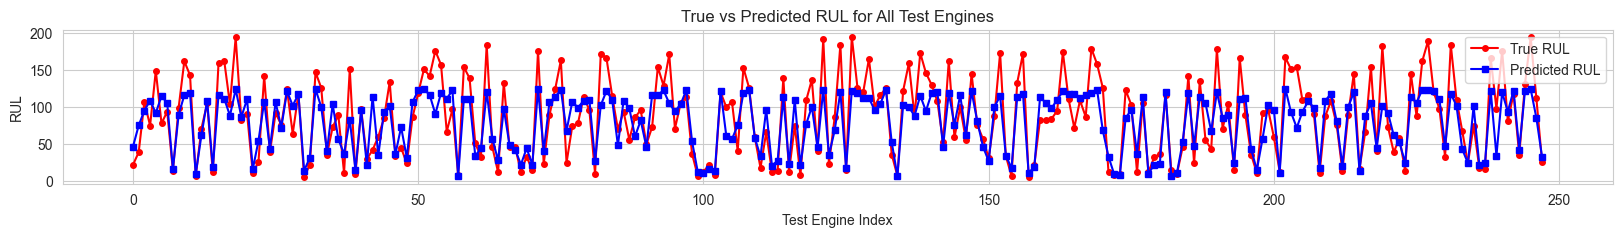

In [7]:
plt.figure(figsize=(20, 2))
plt.plot(true_rul, label="True RUL", color="red", marker='o', markersize=4)
plt.plot(predictions, label="Predicted RUL", color="blue", marker='s', markersize=4)
plt.xlabel('Test Engine Index')
plt.ylabel('RUL')
plt.title('True vs Predicted RUL for All Test Engines')
plt.legend()
plt.grid(True)
plt.show()